# Multi Linear Regression Basic Project

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
!python --version

Python 3.9.16


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import seaborn as sns
from scipy import stats
import scipy

## Read data

In [4]:
data_url="https://s3.amazonaws.com/projex.dezyre.com/multiple-linear-regression-project-for-beginners/materials/EPL_Soccer_MLR_LR.csv"

dfSoccer = pd.read_csv(data_url)
dfSoccer.shape, dfSoccer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202 entries, 0 to 201
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PlayerName              202 non-null    object 
 1   Club                    202 non-null    object 
 2   DistanceCovered(InKms)  202 non-null    float64
 3   Goals                   202 non-null    float64
 4   MinutestoGoalRatio      202 non-null    float64
 5   ShotsPerGame            202 non-null    float64
 6   AgentCharges            202 non-null    int64  
 7   BMI                     202 non-null    float64
 8   Cost                    202 non-null    float64
 9   PreviousClubCost        202 non-null    float64
 10  Height                  202 non-null    float64
 11  Weight                  202 non-null    float64
 12  Score                   202 non-null    float64
dtypes: float64(10), int64(1), object(2)
memory usage: 20.6+ KB


((202, 13), None)

In [5]:
dfSoccer.describe()

,DistanceCovered(InKms),Goals,MinutestoGoalRatio,ShotsPerGame,AgentCharges,BMI,Cost,PreviousClubCost,Height,Weight,Score
count,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000
mean,4.718614,7.108663,43.091584,14.566337,76.876238,22.955891,69.021782,64.873713,180.103960,75.008168,13.507426
std,0.457976,1.800549,3.662989,1.362451,47.501239,2.863933,32.565333,13.070197,9.734494,13.925574,6.189826
min,3.800000,3.300000,35.900000,11.600000,8.000000,16.750000,28.000000,34.360000,148.900000,37.800000,5.630000
25%,4.372500,5.900000,40.600000,13.500000,41.250000,21.082500,43.850000,54.667500,174.000000,66.525000,8.545000
50%,4.755000,6.850000,43.500000,14.700000,65.500000,22.720000,58.600000,63.035000,179.700000,74.400000,11.650000
75%,5.030000,8.275000,45.575000,15.575000,97.000000,24.465000,90.350000,74.750000,186.175000,84.125000,18.080000
max,6.720000,14.300000,59.700000,19.200000,234.000000,34.420000,200.800000,106.000000,209.400000,123.200000,35.520000


In [6]:
def show_corr(df):
    corr = df.corr()
    so = corr.unstack().copy()

    so = pd.DataFrame(so)
    so.reset_index(inplace=True)

    so.columns = ["Feature_A","Feature_B","Correlation"]
    so["Type"] = so.Correlation.map(lambda x: "+" if x>=0 else "-")
    so.Correlation = so.Correlation.abs()
    so.sort_values(by="Correlation",ascending=False,inplace=True)

    so.reset_index(inplace=True,drop=True)

    #so = so[so.Correlation != 1]

    so["FeatureComb1"] = so.Feature_A + " - " + so.Feature_B
    so["FeatureComb2"] = so.Feature_B + " - " + so.Feature_A
    so["NextFeature"] = so["FeatureComb2"].shift(-1)
    so = so[(so.FeatureComb1 == so.NextFeature)]

    so.drop(columns=["Feature_A","Feature_B","FeatureComb2","NextFeature"],inplace=True)
    so.reset_index(inplace=True,drop=True)
    so[['FeatureA', 'FeatureB']] = so.FeatureComb1.str.split(" - ",expand=True)
    so.drop(columns=["FeatureComb1"],inplace=True)
    so = so[["FeatureA","FeatureB","Correlation","Type"]]
    return so

In [7]:
NumericColumns = []
for x in dfSoccer.columns:
    if dfSoccer[x].dtype != object:
        NumericColumns.append(x)

In [8]:
dfSoccer[NumericColumns].corr()

,DistanceCovered(InKms),Goals,MinutestoGoalRatio,ShotsPerGame,AgentCharges,BMI,Cost,PreviousClubCost,Height,Weight,Score
DistanceCovered(InKms),1.000000,0.147098,0.924964,0.888800,0.250865,0.299471,-0.403004,0.550975,0.358854,0.403743,-0.493512
Goals,0.147098,1.000000,0.153333,0.134721,0.131973,0.177032,0.137131,0.102734,0.076958,0.155844,0.108114
MinutestoGoalRatio,0.924964,0.153333,1.000000,0.950757,0.258240,0.320527,-0.449135,0.583375,0.371192,0.423699,-0.532449
ShotsPerGame,0.888800,0.134721,0.950757,1.000000,0.308391,0.382524,-0.435429,0.610986,0.352322,0.455255,-0.531522
AgentCharges,0.250865,0.131973,0.258240,0.308391,1.000000,0.302556,-0.108243,0.317581,0.123255,0.273686,-0.183386
BMI,0.299471,0.177032,0.320527,0.382524,0.302556,1.000000,0.321116,0.713858,0.337097,0.845955,0.187558
Cost,-0.403004,0.137131,-0.449135,-0.435429,-0.108243,0.321116,1.000000,-0.207749,-0.071253,0.154227,0.963017
PreviousClubCost,0.550975,0.102734,0.583375,0.610986,0.317581,0.713858,-0.207749,1.000000,0.802119,0.930904,-0.361850
Height,0.358854,0.076958,0.371192,0.352322,0.123255,0.337097,-0.071253,0.802119,1.000000,0.780906,-0.188022
Weight,0.403743,0.155844,0.423699,0.455255,0.273686,0.845955,0.154227,0.930904,0.780906,1.000000,-0.000162


In [16]:
dfCorr = show_corr(dfSoccer[NumericColumns])

In [21]:
#dfCorr[((dfCorr.FeatureA == "Score") or (dfCorr.FeatureB == "Score"))]
def det_Y(val1, val2, featName):
    if val1 == featName:
        return featName
    elif val2 == featName:
        return featName
    else:
        return pd.NA
dfCorr['Y'] = dfCorr.apply(lambda row: det_Y(row['FeatureA'], row['FeatureB'], "Score"), axis=1)

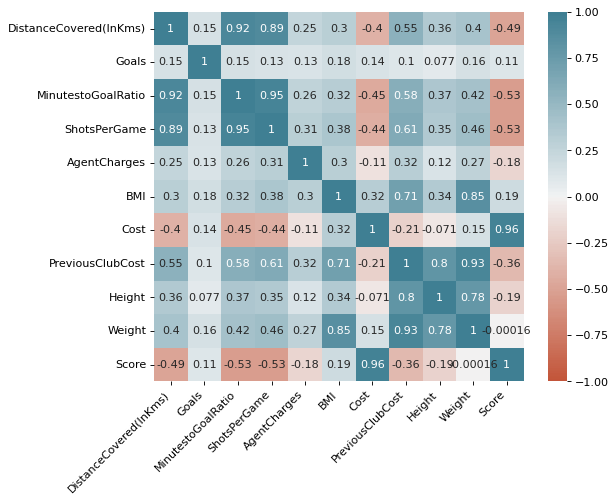

In [13]:
plt.figure(figsize=(8,6), dpi=80)
ax = sns.heatmap(dfSoccer[NumericColumns].corr(),
                 vmin=-1, vmax=1, center=0,
                 cmap=sns.diverging_palette(20,220,n=200),
                 square=True, annot=True)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment="right"
)
plt.show()

In [22]:
dfCorr[~(dfCorr.Y.isna())]

,FeatureA,FeatureB,Correlation,Type,Y
0,Cost,Score,0.963017,+,Score
12,MinutestoGoalRatio,Score,0.532449,-,Score
13,ShotsPerGame,Score,0.531522,-,Score
14,Score,DistanceCovered(InKms),0.493512,-,Score
23,PreviousClubCost,Score,0.361850,-,Score
37,Score,Height,0.188022,-,Score
38,BMI,Score,0.187558,+,Score
39,AgentCharges,Score,0.183386,-,Score
50,Score,Goals,0.108114,+,Score
54,Weight,Score,0.000162,-,Score


In [29]:
dfCorr[(dfCorr.Y.isna())]

,FeatureA,FeatureB,Correlation,Type,Y
1,ShotsPerGame,MinutestoGoalRatio,0.950757,+,<NA>
2,Weight,PreviousClubCost,0.930904,+,<NA>
3,MinutestoGoalRatio,DistanceCovered(InKms),0.924964,+,<NA>
4,ShotsPerGame,DistanceCovered(InKms),0.888800,+,<NA>
5,Weight,BMI,0.845955,+,<NA>
6,PreviousClubCost,Height,0.802119,+,<NA>
7,Weight,Height,0.780906,+,<NA>
8,BMI,PreviousClubCost,0.713858,+,<NA>
9,PreviousClubCost,ShotsPerGame,0.610986,+,<NA>
10,MinutestoGoalRatio,PreviousClubCost,0.583375,+,<NA>


#### Heat map of correlations

In [27]:
dfSoccer.columns.sort_values(), len(dfSoccer.columns)

(Index(['AgentCharges', 'BMI', 'Club', 'Cost', 'DistanceCovered(InKms)',
        'Goals', 'Height', 'MinutestoGoalRatio', 'PlayerName',
        'PreviousClubCost', 'Score', 'ShotsPerGame', 'Weight'],
       dtype='object'),
 13)

In [30]:
dfSoccer.Club.nunique()

3

#### Conclusions from Correlation Analysis

1. <b>Height</b> and <b>Weight</b> have a very weak correlation with Target variable Score
2. <b>BMI</b> and <b>AgentCharges</b> have a very weak correlation as well with Target variable Score
3. ShotsPerGame has high collinearity with <b>MinutestoGoalRatio</b>, <b>DistanceCovered(InKms)</b>. Since ShotsPerGame has higher colinearity with Target variable, we will keep that for further analysis.
4. Weight and PreviousClubCost have high collinearity with each other.
5. <b>AgentCharges</b> has weak correlation with Score as well.
6. Dealing with Categorical variables
    
    a. <b>PlayerName</b> is a categorical feature and there is no colinearity analysis for that.
    
    b. <b>Club</b> is also a categorical variable and there is no colinearity analysis for that either.
    
    c. PlayerName is unique for each row, so we will get rid of it.
    
    d. We will get back to Club later on it has only 3 unique values and we can analyse it later after encoding it.
7. Hence, we are left with the following columns as predictor features -
    
    a. <b>Cost, ShotsPerGame, Goals, PreviousClubCost</b>

In [31]:
X = dfSoccer[["Cost", "ShotsPerGame", "Goals", "PreviousClubCost"]]
y = dfSoccer["Score"]

In [32]:
#Splitting with 70% training, 30% testing data
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = 0.7,
                                                    test_size = 0.3, random_state = 100)

In [33]:
# Fit the linear regression model
x_train_with_intercept = sm.add_constant(x_train)
lr = sm.OLS(y_train, x_train_with_intercept).fit()

print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                  Score   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     726.6
Date:                Fri, 02 Jun 2023   Prob (F-statistic):           1.10e-90
Time:                        03:27:28   Log-Likelihood:                -239.21
No. Observations:                 141   AIC:                             488.4
Df Residuals:                     136   BIC:                             503.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                9.6176      1.554  

#### Dummy Variable transformation for Club feature

In [38]:
clubs = set(dfSoccer.Club)
clubs, len(clubs)

dummyFeatures = pd.get_dummies(dfSoccer["Club"], dtype="int32", drop_first=True)
dummyFeatures.head()

,LIV,MUN
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


In [39]:
dfSoccerEncoded = pd.concat([dfSoccer, dummyFeatures], axis=1)
dfSoccerEncoded.head()

,PlayerName,Club,DistanceCovered(InKms),Goals,MinutestoGoalRatio,ShotsPerGame,AgentCharges,BMI,Cost,PreviousClubCost,Height,Weight,Score,LIV,MUN
0,"Braund, Mr. Owen Harris",MUN,3.96,7.5,37.5,12.3,60,20.56,109.1,63.32,195.9,78.9,19.75,0,1
1,"Allen, Mr. William Henry",MUN,4.41,8.3,38.2,12.7,68,20.67,102.8,58.55,189.7,74.4,21.30,0,1
2,"Moran, Mr. James",MUN,4.14,5.0,36.4,11.6,21,21.86,104.6,55.36,177.8,69.1,19.88,0,1
3,"McCarthy, Mr. Timothy J",MUN,4.11,5.3,37.3,12.6,69,21.88,126.4,57.18,185.0,74.9,23.66,0,1
4,"Palsson, Master. Gosta Leonard",MUN,4.45,6.8,41.5,14.0,29,18.96,80.3,53.20,184.6,64.6,17.64,0,1


In [40]:
X = dfSoccerEncoded[["Cost", "ShotsPerGame", "Goals", "PreviousClubCost", "LIV", "MUN"]]
y = dfSoccerEncoded["Score"]

#Splitting with 70% training, 30% testing data
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = 0.7,
                                                    test_size = 0.3, random_state = 100)

# Fit the linear regression model
x_train_with_intercept = sm.add_constant(x_train)
lr = sm.OLS(y_train, x_train_with_intercept).fit()

print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                  Score   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     573.5
Date:                Fri, 02 Jun 2023   Prob (F-statistic):           6.06e-93
Time:                        03:38:11   Log-Likelihood:                -226.78
No. Observations:                 141   AIC:                             467.6
Df Residuals:                     134   BIC:                             488.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                6.4968      1.567  

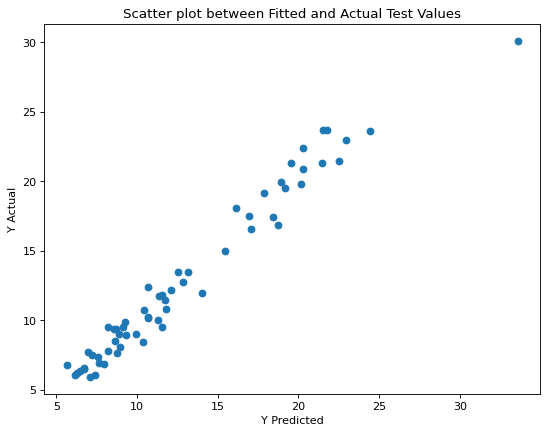

In [44]:
#Look at model plot
plt.figure(figsize=(8, 6), dpi=80)
x_test_with_intercept = sm.add_constant(x_test)
y_test_fitted = lr.predict(x_test_with_intercept)

#plot the scatter plot between the fitted values and actual test values for repsonse variable
plt.scatter(y_test_fitted, y_test)
plt.xlabel("Y Predicted")
plt.ylabel("Y Actual")
plt.title("Scatter plot between Fitted and Actual Test Values")
plt.show()